## 0. data load

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

train = pd.read_csv('../data/train.csv').drop(columns='ID')
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns='y'), train['y'], test_size=0.2, random_state=42)

X_test = pd.read_csv('../data/test.csv').drop(columns='ID')

## 1. preprocessing

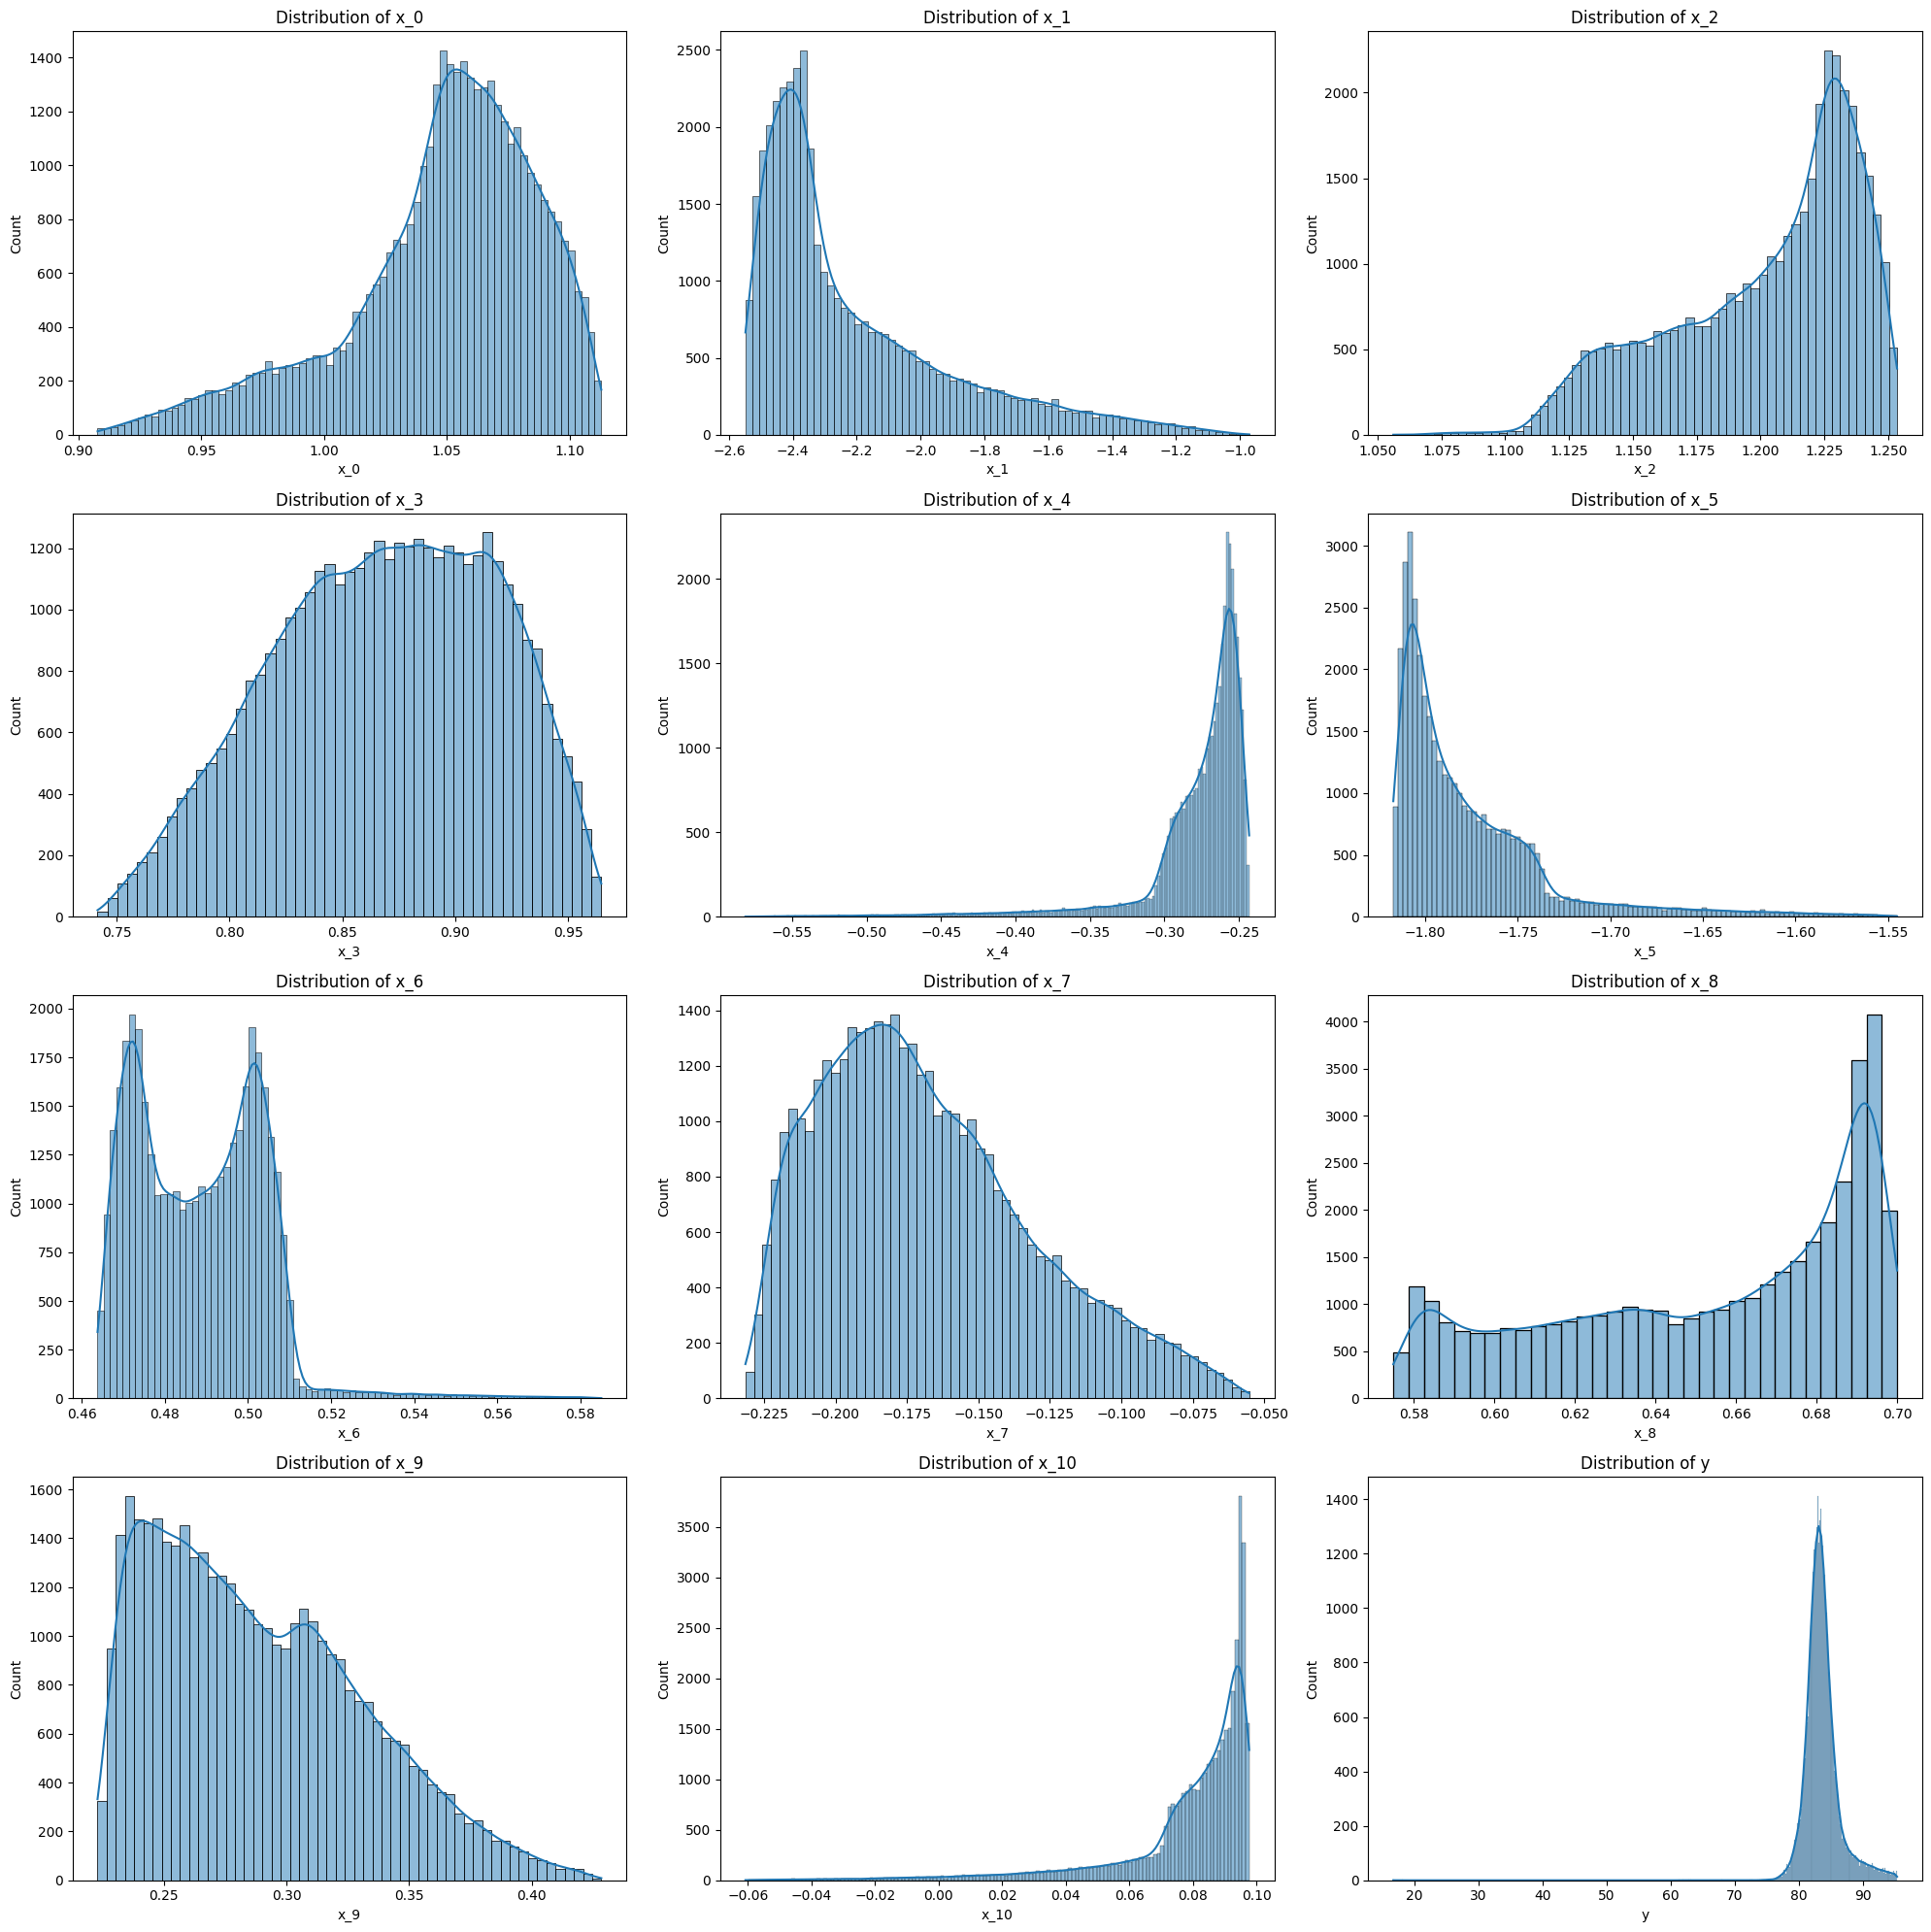

EDA 결과에 따라 
- Skewed Feature가 존재함을 확인 >> skew 조절
- peak가 2개인 Bimodal Feature도 존재함을 확인 >> detect한 후 skew 조절
- 둘 중 아무것에도 해당되지 않는 경우 >> 그냥 둔다

In [2]:
from sklearn.cluster import KMeans

# skew 조절
def skew_adjustment(data):
    
    def detect_bimodal(data):
        bimodal_features = []
        for col in data.columns:
            hist, bin_edges = np.histogram(data[col].dropna(), bins=10)
            peaks = np.where(hist > np.mean(hist))[0]
            if len(peaks) > 1:
                bimodal_features.append(col)
            
        return bimodal_features
    
    def detect_skewness(data, skew_threshold=0.5):
        skew_features = data.apply(lambda x: x.skew())
        return skew_features[skew_features.abs() > skew_threshold].index.tolist()
    
    skewed_features = detect_skewness(data)
    bimodal_features = detect_bimodal(data)
    
    adjusted_data = data.copy()
    
    transformer_y = PowerTransformer(method='yeo-johnson') # Yeo-Johnson transform
    
    for col in data.columns:
        if col in skewed_features:
            adjusted_data[col] = transformer_y.fit_transform(data[[col]])
        
        elif col in bimodal_features:
            kmeans = KMeans(n_clusters=2, random_state=42)
            labels = kmeans.fit_predict(data[[col]])
            
            d_0 = data[col][labels==0].values.reshape(-1,1)
            d_1 = data[col][labels==1].values.reshape(-1,1)
            
            adjusted_d_0 = transformer_y.fit_transform(d_0)
            adjusted_d_1 = transformer_y.fit_transform(d_1)
            
            adjusted_data.loc[labels ==0, col] = adjusted_d_0.flatten()
            adjusted_data.loc[labels ==1, col] = adjusted_d_1.flatten()
        
        else:
            adjusted_data[col] = data[col]
        
    return adjusted_data
            
# scaler 조정
def scaler(scaler, X_train, X_val, X_test):
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_val_scaled, X_test_scaled       

## 2. simple diffusion model

In [3]:
# 간단한 Diffusion Model 정의

import torch
import torch.nn as nn
import torch.optim as optim

class DiffusionModel(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(DiffusionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), # 일단 간단하게 만듦
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,input_dim)
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed

In [4]:
def TrainDiffusionModel(X_train, latent_dim, epochs =100, lr=0.001):
    input_dim = X_train.shape[1]
    using_model = DiffusionModel(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(using_model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        using_model.train()
        optimizer.zero_grad()
        
        latent, reconstructed = using_model(X_train)
        loss = criterion(reconstructed, X_train)
        
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 10 == 0 :
            print(f'Epoch {epoch+1}/{epochs} : loss {loss.item()}')
            
    return using_model

## 3. AutoML을 사용해 성능이 좋은 regression model 5개 추출 (MSE 기준)

In [5]:
from pycaret.regression import setup, compare_models, pull, save_model, create_model

regressor = setup(data = train, target='y', session_id=42)
best_model = compare_models()
results = pull()

top5_models = results.sort_values(by='MSE').head(5).index.tolist()
top5_models

,Description,Value
0,Session id,42
1,Target,y
2,Target type,Regression
3,Original data shape,"(40118, 12)"
4,Transformed data shape,"(40118, 12)"
5,Transformed train set shape,"(28082, 12)"
6,Transformed test set shape,"(12036, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,1.2057,2.8778,1.6879,0.6054,0.0220,0.0146,0.0230
lr,Linear Regression,1.2057,2.8779,1.6879,0.6053,0.0220,0.0146,0.1250
gbr,Gradient Boosting Regressor,1.2082,2.8856,1.6902,0.6043,0.0220,0.0146,0.7280
ridge,Ridge Regression,1.2080,2.8875,1.6908,0.6040,0.0220,0.0146,0.0760
lightgbm,Light Gradient Boosting Machine,1.2128,2.9023,1.6953,0.6019,0.0221,0.0147,0.5280
huber,Huber Regressor,1.2010,2.9304,1.7038,0.5980,0.0221,0.0145,0.0460
lar,Least Angle Regression,1.2256,2.9415,1.7070,0.5965,0.0222,0.0148,0.0150
et,Extra Trees Regressor,1.2380,2.9828,1.7190,0.5907,0.0223,0.0150,0.3010
rf,Random Forest Regressor,1.2361,2.9976,1.7231,0.5888,0.0224,0.0150,1.1140
omp,Orthogonal Matching Pursuit,1.3052,3.2432,1.7936,0.5546,0.0231,0.0158,0.0140


['br', 'lr', 'gbr', 'ridge', 'lightgbm']

In [6]:
train_models = {}
for model_name in top5_models:
    model = create_model(model_name)
    train_models[model_name] = model
    save_model(model, f'result/{model_name}')
    print(f'model_name : {model_name}')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2047,2.5206,1.5877,0.6348,0.0186,0.0144
1,1.1854,2.5111,1.5846,0.6334,0.0186,0.0142
2,1.2119,4.2253,2.0556,0.4940,0.0353,0.0157
3,1.1853,2.5437,1.5949,0.6493,0.0189,0.0141
4,1.2084,2.6588,1.6306,0.6297,0.0191,0.0144
5,1.2294,2.7242,1.6505,0.6158,0.0196,0.0147
6,1.1992,2.4761,1.5736,0.6330,0.0184,0.0143
7,1.2266,2.5953,1.6110,0.6283,0.0189,0.0146
8,1.1965,2.5568,1.5990,0.6219,0.0188,0.0143


Transformation Pipeline and Model Successfully Saved
model_name : br


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2047,2.5204,1.5876,0.6348,0.0186,0.0144
1,1.1855,2.5115,1.5848,0.6333,0.0186,0.0142
2,1.2119,4.2261,2.0558,0.4939,0.0354,0.0157
3,1.1853,2.5433,1.5948,0.6494,0.0189,0.0141
4,1.2084,2.6586,1.6305,0.6297,0.0191,0.0144
5,1.2293,2.7239,1.6504,0.6159,0.0196,0.0147
6,1.1993,2.4763,1.5736,0.6330,0.0184,0.0143
7,1.2268,2.5962,1.6113,0.6282,0.0189,0.0146
8,1.1965,2.5566,1.5989,0.6220,0.0188,0.0143


Transformation Pipeline and Model Successfully Saved
model_name : lr


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2065,2.5252,1.5891,0.6342,0.0186,0.0144
1,1.1822,2.5082,1.5837,0.6338,0.0186,0.0141
2,1.2175,4.2449,2.0603,0.4916,0.0354,0.0157
3,1.1883,2.5604,1.6001,0.6471,0.0189,0.0142
4,1.2181,2.6935,1.6412,0.6249,0.0192,0.0145
5,1.2435,2.7794,1.6671,0.6081,0.0198,0.0149
6,1.1997,2.4664,1.5705,0.6345,0.0184,0.0143
7,1.2241,2.5611,1.6003,0.6332,0.0188,0.0146
8,1.1986,2.5702,1.6032,0.6199,0.0189,0.0143


Transformation Pipeline and Model Successfully Saved
model_name : gbr


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2072,2.5307,1.5908,0.6333,0.0186,0.0144
1,1.1858,2.5122,1.5850,0.6332,0.0186,0.0142
2,1.2140,4.2297,2.0566,0.4934,0.0354,0.0157
3,1.1885,2.5571,1.5991,0.6475,0.0189,0.0142
4,1.2119,2.6795,1.6369,0.6268,0.0191,0.0144
5,1.2322,2.7373,1.6545,0.6140,0.0196,0.0148
6,1.2021,2.4899,1.5779,0.6310,0.0185,0.0143
7,1.2272,2.5909,1.6096,0.6290,0.0189,0.0146
8,1.1990,2.5674,1.6023,0.6204,0.0189,0.0143


Transformation Pipeline and Model Successfully Saved
model_name : ridge


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2113,2.5527,1.5977,0.6302,0.0187,0.0144
1,1.1990,2.5681,1.6025,0.6251,0.0188,0.0143
2,1.2226,4.2758,2.0678,0.4879,0.0354,0.0158
3,1.2003,2.6004,1.6126,0.6415,0.0190,0.0143
4,1.2218,2.6712,1.6344,0.6280,0.0191,0.0146
5,1.2343,2.7358,1.6540,0.6142,0.0196,0.0148
6,1.2012,2.4808,1.5750,0.6323,0.0185,0.0143
7,1.2292,2.5976,1.6117,0.6280,0.0189,0.0147
8,1.2057,2.5971,1.6115,0.6160,0.0190,0.0144


Transformation Pipeline and Model Successfully Saved
model_name : lightgbm


## 4. 모든 케이스에 대해 실험

In [7]:
from concurrent.futures import ThreadPoolExecutor

# 모든 경우의 수 실험
def experiment(TrainDiffModel, X_train, X_val, X_test, y_train, y_val, train_models):
    results = {}
    submission_data = {}    

    # case 정의
    cases = {
        # 1. Skew 조절
        '1-1 : Skew Adjusted + Standard Scaler' : (skew_adjustment(X_train), skew_adjustment(X_val), skew_adjustment(X_test),StandardScaler()),
        '1-2 : Skew Adjusted + MinMax Scaler' : (skew_adjustment(X_train), skew_adjustment(X_val), skew_adjustment(X_test), MinMaxScaler()),
        # '1-3 : Skew Adjusted + Scaler (x)' :  (skew_adjustment(X_train), skew_adjustment(X_val), skew_adjustment(X_test), None),
        
        # 2. Skew 조절 x
        '2-1 : Skew Adjusted (x) + Standard Scaler' : (X_train, X_val, X_test, StandardScaler()),
        '2-2 : Skew Adjusted (x) + MinMax Scaler' : (X_train, X_val, X_test, MinMaxScaler())
        # '2-3 : Skew Adjusted (x) + Scaler (x)' :  (X_train, X_val, X_test, None) # 스케일링 하지 않는 경우 >> 오류 발생 ㅠ
    }
    
    def run_case(case_name, case_data):
        X_train_case, X_val_case, X_test_case, scaler_choice = case_data
        
        if scaler_choice:
            X_train_case, X_val_case, X_test_case = scaler(scaler_choice, X_train_case, X_val_case, X_test_case)
        else:
            X_train_case, X_val_case, X_test_case = X_train_case.to_numpy(), X_val_case.to_numpy(), X_test_case.to_numpy()
        
        # numpy -> tensor로 변환
        X_train_case_t = torch.tensor(X_train_case, dtype=torch.float32)
        X_val_case_t = torch.tensor(X_val_case, dtype=torch.float32)
        X_test_case_t = torch.tensor(X_test_case, dtype=torch.float32)
        
        # TrainDiffusionModel을 통한 latent variable 생성
        diff_model = TrainDiffModel(X_train=X_train_case_t, latent_dim=10, epochs = 100, lr = 0.001)
        
        diff_model.eval()
        
        with torch.no_grad():
            latent_train_diff, _ = diff_model(X_train_case_t)
            latent_val_diff, _ = diff_model(X_val_case_t)
            latent_test_diff, _ = diff_model(X_test_case_t)
        
        # tensor -> numpy
        latent_train_diff_np = latent_train_diff.detach().numpy()
        latent_val_diff_np = latent_val_diff.detach().numpy()
        latent_test_diff_np = latent_test_diff.detach().numpy()
    
        case_results = {}
        
        # 성능이 좋았던 AutoML 모델을 사용하여 각각의 케이스에 대해 prediction
        for model_name, model in train_models.items():
            
            # Diffusion Model을 사용한 학습
            model.fit(latent_train_diff_np, y_train)
            val_loss = mean_squared_error(y_val, model.predict(latent_val_diff_np))
            preds = model.predict(latent_test_diff_np)
            
            case_results[f'{case_name} - {model_name}'] = val_loss
            submission_data[f'{case_name} - {model_name}'] = preds
        
        return case_results, submission_data
    
    # ThreadPoolExecutor로 각 케이스를 병렬로 실행
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(run_case, case_name, case_data): case_name for case_name, case_data in cases.items()}
        
        for future in futures:
            case_results, case_submission_data = future.result()
            results.update(case_results)
            submission_data.update(case_submission_data)
    
    # 가장 좋은 성능을 보인 케이스의 예측 결과를 submission.csv로 저장
    best_case = min(results, key=results.get)
    
    submission = pd.read_csv('../data/sample_submission.csv')
    submission['y'] = submission_data[best_case]
    submission.to_csv(f'result/{best_case}_submission.csv',index=False)
    
    return pd.DataFrame(list(results.items()), columns=['Case', 'Validation Loss']).sort_values(by='Validation Loss', ascending=True)

In [8]:
experiment(TrainDiffusionModel, X_train, X_val, X_test, y_train, y_val, train_models)

Epoch 10/100 : loss 0.916654646396637
Epoch 10/100 : loss 0.2135157287120819
Epoch 10/100 : loss 0.20261512696743011
Epoch 10/100 : loss 0.910088062286377
Epoch 20/100 : loss 0.05112675204873085
Epoch 20/100 : loss 0.6106879711151123
Epoch 20/100 : loss 0.538438618183136
Epoch 20/100 : loss 0.07491356134414673
Epoch 30/100 : loss 0.03853683918714523
Epoch 30/100 : loss 0.24758249521255493
Epoch 30/100 : loss 0.2533486783504486
Epoch 30/100 : loss 0.06038796901702881
Epoch 40/100 : loss 0.10284335166215897
Epoch 40/100 : loss 0.037060562521219254
Epoch 40/100 : loss 0.15619070827960968
Epoch 40/100 : loss 0.06118518486618996
Epoch 50/100 : loss 0.06705362349748611
Epoch 50/100 : loss 0.10950435698032379
Epoch 50/100 : loss 0.03448395058512688
Epoch 50/100 : loss 0.055879075080156326
Epoch 60/100 : loss 0.05635056272149086
Epoch 60/100 : loss 0.04632002115249634
Epoch 60/100 : loss 0.03179790824651718
Epoch 60/100 : loss 0.07141529768705368
Epoch 70/100 : loss 0.028340429067611694
Epoch 

,Case,Validation Loss
11,2-1 : Skew Adjusted (x) + Standard Scaler - lr,2.590131
10,2-1 : Skew Adjusted (x) + Standard Scaler - br,2.590395
13,2-1 : Skew Adjusted (x) + Standard Scaler - ridge,2.590436
16,2-2 : Skew Adjusted (x) + MinMax Scaler - lr,2.607848
15,2-2 : Skew Adjusted (x) + MinMax Scaler - br,2.608629
18,2-2 : Skew Adjusted (x) + MinMax Scaler - ridge,2.618281
4,1-1 : Skew Adjusted + Standard Scaler - lightgbm,2.626639
14,2-1 : Skew Adjusted (x) + Standard Scaler - li...,2.630271
0,1-1 : Skew Adjusted + Standard Scaler - br,2.647380
3,1-1 : Skew Adjusted + Standard Scaler - ridge,2.647383
